<a href="https://colab.research.google.com/github/6797114108111/sentiment-model/blob/master/aurum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install nltk
!pip install pandas
!pip install unidecode

In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Data loading

### Subtask:
Load the dataset.


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df = pd.read_csv('/content/drive/My Drive/aurum/sentimentdataset_with_scores.csv')
display(df.head())

,unnamed,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,1,Enjoying a beautiful day at the park! ...,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,2,Traffic was terrible this morning. ...,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,3,Just finished an amazing workout! ?? ...,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,4,Excited about the upcoming weekend getaway! ...,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,5,Trying out a new recipe for dinner tonight. ...,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


## Data exploration

### Subtask:
Explore the loaded dataset to understand its characteristics.


Shape of the DataFrame: (732, 15)

Data Types:
unnamed                 int64
Text                   object
Timestamp              object
User                   object
Platform               object
Hashtags               object
Retweets                int64
Likes                   int64
Country                object
Year                    int64
Month                   int64
Day                     int64
Hour                    int64
sentiment_score       float64
sentiment_category     object
dtype: object

Missing Values:
unnamed               0
Text                  0
Timestamp             0
User                  0
Platform              0
Hashtags              0
Retweets              0
Likes                 0
Country               0
Year                  0
Month                 0
Day                   0
Hour                  0
sentiment_score       0
sentiment_category    0
dtype: int64

Descriptive statistics for 'sentiment_score':
count    732.000000
mean       0.255119
std        0

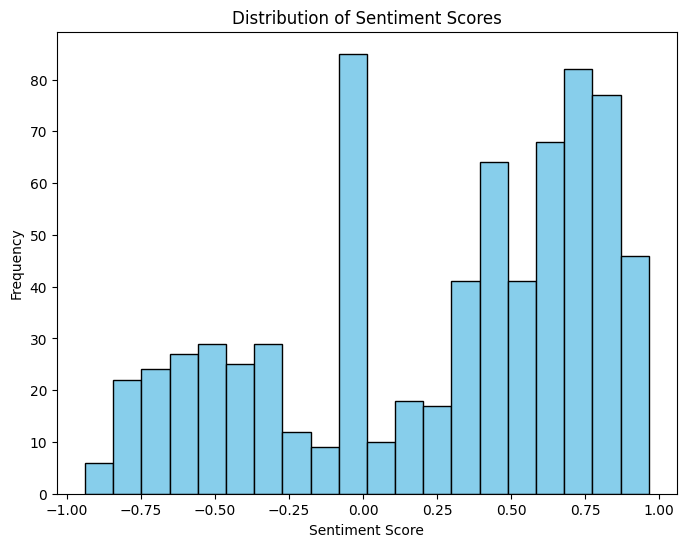

In [71]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine data types
print("\nData Types:")
print(df.dtypes)

# Identify the text column (assuming it's named 'Text' or similar)
text_column = 'Text'  # Replace with the actual column name if different

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Analyze the distribution of 'sentiment_score'
print("\nDescriptive statistics for 'sentiment_score':")
print(df['sentiment_score'].describe())

# Analyze the distribution of 'sentiment_category'
print("\nUnique values and counts in 'sentiment_category':")
print(df['sentiment_category'].value_counts())

# Basic visualization (histogram for sentiment score)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

## Data cleaning

### Subtask:
Clean the text data in the 'Text' column of the DataFrame `df`.


In [72]:
df.columns

Index(['unnamed', 'Text', 'Timestamp', 'User', 'Platform', 'Hashtags',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'sentiment_score', 'sentiment_category'],
      dtype='object')

In [73]:
df.drop("unnamed", axis=1, inplace=True)

In [74]:

# Define a robust text cleaning function
def clean_text(text):
    if isinstance(text, str):
        text = unidecode(text)  # Normalize accented characters like é -> e
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
        text = text.strip().lower()  # Trim and convert to lowercase
    else:
        text = ""
    return text

# Apply cleaning to the 'Text' column
df['Text'] = df['Text'].apply(clean_text)

# Display the first few cleaned rows
display(df.head())

# Optional: Show a few before-and-after samples for verification
print("🧼 Sample cleaning preview:")
for i in range(3):
    raw_text = df['Text'].iloc[i]
    cleaned_text = clean_text(raw_text)
    print(f"Original [{i}]:", raw_text)
    print(f"Cleaned  [{i}]:", cleaned_text)
    print("-" * 40)

,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,enjoying a beautiful day at the park,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,traffic was terrible this morning,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,just finished an amazing workout,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,excited about the upcoming weekend getaway,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,trying out a new recipe for dinner tonight,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


🧼 Sample cleaning preview:
Original [0]: enjoying a beautiful day at the park
Cleaned  [0]: enjoying a beautiful day at the park
----------------------------------------
Original [1]: traffic was terrible this morning
Cleaned  [1]: traffic was terrible this morning
----------------------------------------
Original [2]: just finished an amazing workout
Cleaned  [2]: just finished an amazing workout
----------------------------------------


In [75]:
# Download 'punkt_tab' before tokenization
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_clean_text(text):
    if isinstance(text, str):
        text = unidecode(text)  # Normalize accents
        text = re.sub(r'http\S+|@\w+|#\w+', '', text)  # Remove URLs, mentions, hashtags
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\s+', ' ', text).strip().lower()  # Normalize spaces and lowercase
        tokens = nltk.word_tokenize(text)  # Tokenize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    return ""

df['Cleaned_Text'] = df['Text'].apply(advanced_clean_text)
display(df[['Text', 'Cleaned_Text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Text,Cleaned_Text
0,enjoying a beautiful day at the park,enjoying beautiful day park
1,traffic was terrible this morning,traffic terrible morning
2,just finished an amazing workout,finished amazing workout
3,excited about the upcoming weekend getaway,excited upcoming weekend getaway
4,trying out a new recipe for dinner tonight,trying new recipe dinner tonight


## Data preparation

### Subtask:
Prepare the data for modeling by splitting it into training, validation, and testing sets, and performing necessary text transformations for each model (Logistic Regression, LSTM, and Roberta).


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define features (X) and target variables (y)
X = df['Text']
y_score = df['sentiment_score']
y_category = df['sentiment_category']

# Split data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train_score, y_temp_score, y_train_category, y_temp_category = train_test_split(
    X, y_score, y_category, test_size=0.2, random_state=42
)
X_val, X_test, y_val_score, y_test_score, y_val_category, y_test_category = train_test_split(
    X_temp, y_temp_score, y_temp_category, test_size=0.5, random_state=42
)

# Logistic Regression Preparation: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# LSTM and Roberta Preparation: Tokenization and Sequencing
max_sequence_length = 100  # Adjust as needed
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Limit vocabulary size
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert target variables to numpy arrays for LSTM and Roberta
y_train_score = np.array(y_train_score)
y_val_score = np.array(y_val_score)
y_test_score = np.array(y_test_score)

# For simplicity, convert sentiment category to numerical representation for LSTM and Roberta
category_mapping = {'Positive': 2, 'Negative': 1, 'Neutral': 0}
y_train_category = np.array([category_mapping[category] for category in y_train_category])
y_val_category = np.array([category_mapping[category] for category in y_val_category])
y_test_category = np.array([category_mapping[category] for category in y_test_category])

# Check the sizes of the datasets after processing
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 585
Validation set size: 73
Test set size: 74


## Splitting the dataset

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with a limit of 5000 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test data using the fitted vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shape of the resulting TF-IDF matrices
print(f"TF-IDF training matrix shape: {X_train_tfidf.shape}")
print(f"TF-IDF validation matrix shape: {X_val_tfidf.shape}")
print(f"TF-IDF test matrix shape: {X_test_tfidf.shape}")


TF-IDF training matrix shape: (585, 2259)
TF-IDF validation matrix shape: (73, 2259)
TF-IDF test matrix shape: (74, 2259)


# Prediction for Sentiment Classification.

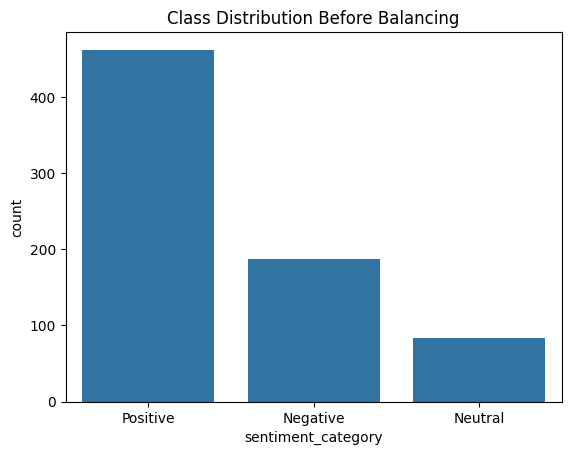

sentiment_category
Positive    462
Negative    187
Neutral      83
Name: count, dtype: int64


In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment_category')
plt.title("Class Distribution Before Balancing")
plt.show()

print(df['sentiment_category'].value_counts())


In [79]:
from imblearn.over_sampling import SMOTE

# Only apply SMOTE on the training TF-IDF features and category labels
smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_category_balanced = smote.fit_resample(X_train_tfidf, y_train_category)

# Check new class distribution
from collections import Counter
print("New training label distribution after SMOTE:", Counter(y_train_category_balanced))


New training label distribution after SMOTE: Counter({np.int64(2): 368, np.int64(1): 368, np.int64(0): 368})


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the Logistic Regression classifier
clf_category = LogisticRegression(max_iter=1000, random_state=42)
clf_category.fit(X_train_tfidf_balanced, y_train_category_balanced)

# Predict on the validation set
y_val_pred_category = clf_category.predict(X_val_tfidf)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(y_val_category, y_val_pred_category))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_val_category, y_val_pred_category))

print("\nAccuracy Score:", accuracy_score(y_val_category, y_val_pred_category))



Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.86      0.78      0.82        23
           2       0.83      0.86      0.84        44

    accuracy                           0.81        73
   macro avg       0.73      0.72      0.72        73
weighted avg       0.81      0.81      0.81        73


Confusion Matrix:

[[ 3  0  3]
 [ 0 18  5]
 [ 3  3 38]]

Accuracy Score: 0.8082191780821918


In [81]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
clf_category = LogisticRegression(max_iter=1000, class_weight="balanced",random_state=42)

# Fit the model on the training set
clf_category.fit(X_train_tfidf, y_train_category)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on validation data
y_val_pred_category = clf_category.predict(X_val_tfidf)

# Evaluation metrics
print("📋 Classification Report:\n")
print(classification_report(y_val_category, y_val_pred_category, target_names=['Negative', 'Neutral', 'Positive']))

print("\n✅ Accuracy Score:", accuracy_score(y_val_category, y_val_pred_category))


📋 Classification Report:

              precision    recall  f1-score   support

    Negative       0.33      0.50      0.40         6
     Neutral       0.83      0.87      0.85        23
    Positive       0.88      0.80      0.83        44

    accuracy                           0.79        73
   macro avg       0.68      0.72      0.69        73
weighted avg       0.82      0.79      0.80        73


✅ Accuracy Score: 0.7945205479452054


In [83]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type (l1/l2)
    'solver': ['lbfgs', 'liblinear'],  # Solvers
    'max_iter': [500, 1000]  # Iterations for convergence
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train_tfidf_balanced, y_train_category_balanced)

# Get best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the validation set with the best model
y_val_pred_category_tuned = grid_search.best_estimator_.predict(X_val_tfidf)

# Evaluate the tuned model
print("📋 Classification Report (After Hyperparameter Tuning):")
print(classification_report(y_val_category, y_val_pred_category_tuned))

print("\n🔁 Confusion Matrix:")
print(confusion_matrix(y_val_category, y_val_pred_category_tuned))

print("\n✅ Accuracy Score:", accuracy_score(y_val_category, y_val_pred_category_tuned))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
📋 Classification Report (After Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.90      0.83      0.86        23
           2       0.83      0.86      0.84        44

    accuracy                           0.81        73
   macro avg       0.69      0.67      0.68        73
weighted avg       0.81      0.81      0.81        73


🔁 Confusion Matrix:
[[ 2  0  4]
 [ 0 19  4]
 [ 4  2 38]]

✅ Accuracy Score: 0.8082191780821918


## Model evaluation

### Subtask:
Evaluate the performance of the trained Logistic Regression model.


## Predict

In [84]:
#test the model on new texts
def predict_sentiment(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    pred = clf_category.predict(text_tfidf)[0]  # Predict sentiment class

    # The prediction 'pred' is already the sentiment label (e.g., 'Positive')
    # No need to use sentiment_labels dictionary
    sentiment_label = pred

    print(f"Predicted Sentiment: {sentiment_label}")

# Example Predictions
predict_sentiment("I love this product! It's amazing.")
predict_sentiment("This is the worst experience ever.")
predict_sentiment("The service was okay, not great but not bad.")
predict_sentiment("This must be the worse salad I've tasted. ")

Predicted Sentiment: 2
Predicted Sentiment: 2
Predicted Sentiment: 1
Predicted Sentiment: 1


save the model

In [85]:
import pickle

# Save the trained Logistic Regression model using pickle
with open('sentiment_classifier.pkl', 'wb') as file:
    pickle.dump(clf_category, file)

# Save the TF-IDF vectorizer using pickle
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

# Model deployment (streamlit)

In [86]:
!pip install streamlit

In [87]:
import streamlit as st
import pickle

# Load the trained model and TF-IDF vectorizer
with open('sentiment_classifier.pkl', 'rb') as file:
    model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Define a function for prediction
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

# Streamlit app layout
st.title('Sentiment Analysis App')
st.write('Enter text to analyze:')

user_input = st.text_input('Input Text')

if st.button('Predict'):
    if user_input:
        prediction = predict_sentiment(user_input)
        st.write(f'Predicted Sentiment: {prediction}')
    else:
        st.write('Please enter some text.')

2025-04-16 08:15:17.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.739 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 08:15:17.747 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [88]:
%%writefile app.py
import streamlit as st
import pickle

   # Load the trained model and TF-IDF vectorizer
   with open('/content/sentiment_classifier.pkl', 'rb') as file: # Update the path if your model is saved elsewhere
       model = pickle.load(file)

   with open('/content/tfidf_vectorizer.pkl', 'rb') as file: # Update the path if your vectorizer is saved elsewhere
       vectorizer = pickle.load(file)

 with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Define a function for prediction
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

# Streamlit app layout
st.title('Sentiment Analysis App')
st.write('Enter text to analyze:')

user_input = st.text_input('Input Text')

if st.button('Predict'):
    if user_input:
        prediction = predict_sentiment(user_input)
        st.write(f'Predicted Sentiment: {prediction}')
    else:
        st.write('Please enter some text.')

Writing app.py


In [89]:
%%writefile app.py
import streamlit as st
import pickle

# Load the trained model and TF-IDF vectorizer
with open('/content/sentiment_classifier.pkl', 'rb') as file:  # Update the path if your model is saved elsewhere
    model = pickle.load(file)

with open('/content/tfidf_vectorizer.pkl', 'rb') as file:  # Update the path if your vectorizer is saved elsewhere
    vectorizer = pickle.load(file)

# Define a function for prediction
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

# Streamlit app layout
st.title('Sentiment Analysis App')
st.write('Enter text to analyze:')

# Display "Hello World" once
st.write("Hello World!")  # This will be displayed when the app starts

user_input = st.text_input('Input Text')

if st.button('Predict'):
    if user_input:
        prediction = predict_sentiment(user_input)
        st.write(f'Predicted Sentiment: {prediction}')
    else:
        st.write('Please enter some text.')

Overwriting app.py


In [90]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.22.8:8501

⠴⠦your url is: https://sour-zoos-return.loca.lt
  Stopping...
^C
